In [17]:
%matplotlib widget
from dataclasses import dataclass
from typing import Callable, Tuple
import functools
import numpy as np
import matplotlib.pyplot as plt
import scipy

# from time import perf_counter
# from scipy.stats import multivariate_normal

# Some useful utilities
from mcmc_utils_and_plot import scatter_matrix, sub_sample_data, eval_func_on_grid, lognormpdf


# RAND_SEED = 0 # 1 diag, 0.9 off-diag
# RAND_SEED = 1 # identity cov
# RAND_SEED = 2 # .55 diag, .45 off-diag
RAND_SEED = 3 # 1 diag, 0.9 off-diag # pick this
# RAND_SEED = 4 # identity cov
# RAND_SEED = 5 # # .6 diag, .5 off-diag

In [18]:
# Set up Satellite Dynamics

X_NAMES = [r'$q_1$', r'$q_2$', r'$q_3$', r'$q_4$', r'$\omega_1$', r'$\omega_2$', r'$\omega_3$']
K1_TRUE = 5
K2_TRUE = 5
J12_TRUE = 1.2
NOISE_STD = 0.05


def x0(q1=-0.6, q2=0.4, q3=-0.2, w1=1.2, w2=-1.5, w3=0.2):
    return np.array([q1, q2, q3, np.sqrt(1-q1**2-q2**2-q3**2), w1, w2, w3])


print(f"x0 = {np.array2string(x0(), precision=3, floatmode='fixed')}")


def M(q1, q2, q3, q4):
    return 0.5 * (q4 * np.eye(3) + np.array([[0, -q3, q2],
                                            [q3, 0, -q1],
                                             [-q2, q1, 0]]))


print(f'\nM(x0) =\n{M(*x0()[:4])}')


def tau(k1, q1, q2, q3, q4, k2, w1, w2, w3):
    return -k1 * M(q1, q2, q3, q4).T @ np.array([[q1],
                                                 [q2],
                                                 [q3]]) \
        - k2 * np.clip(np.array([[w1],
                                 [w2],
                                 [w3]]),
                       -1, 1)


print(f'\nTrue tau(x0) =\n{tau(K1_TRUE, *x0()[:4], K2_TRUE, *x0()[4:])}')


def J(J12):
    return np.array([[20, J12, 0.9],
                     [J12, 17, 1.4],
                     [0.9, 1.4, 15]])


print(f'\nTrue J =\n{J(J12_TRUE)}')


def f(t, x, k1, k2, J12):
    q1, q2, q3, q4, w1, w2, w3 = x
    [[tau1], [tau2], [tau3]] = tau(k1, q1, q2, q3, q4, k2, w1, w2, w3)
    q_dot = 0.5 * np.array([[q4*w1 - q3*w2 + q2*w3],
                            [q3*w1 + q4*w2 - q1*w3],
                            [-q2*w1 + q1*w2 + q4*w3],
                            [-q1*w1 - q2*w2 - q3*w3]])

    J_ = J(J12)
    [[J11, J12, J13], [J21, J22, J23], [J31, J32, J33]] = J_
    w_dot = np.linalg.inv(J_) @ np.array([
        [-(w2*(J31*w1 + J32*w2 + J33*w3) - w3*(J21*w1 + J22*w2 + J23*w3)) + tau1],
        [-(w3*(J11*w1 + J12*w2 + J13*w3) - w1*(J31*w1 + J32*w2 + J33*w3)) + tau2],
        [-(w1*(J21*w1 + J22*w2 + J23*w3) - w2*(J11*w1 + J12*w2 + J13*w3)) + tau3]])

    return np.vstack((q_dot, w_dot)).flatten()  # so in same format as x0


def f_true(t, x):
    return f(t, x, K1_TRUE, K2_TRUE, J12_TRUE)


print(f"\nf_true(0, x0) = {np.array2string(f_true(0, x0()), precision=3, floatmode='fixed')}")

x0 = [-0.600  0.400 -0.200  0.663  1.200 -1.500  0.200]

M(x0) =
[[ 0.33166248  0.1         0.2       ]
 [-0.1         0.33166248  0.3       ]
 [-0.2        -0.3         0.33166248]]

True tau(x0) =
[[-4.00501256]
 [ 4.33667504]
 [-0.66833752]]

True J =
[[20.   1.2  0.9]
 [ 1.2 17.   1.4]
 [ 0.9  1.4 15. ]]

f_true(0, x0) = [ 0.288 -0.557  0.276  0.680 -0.283  0.183 -0.380]


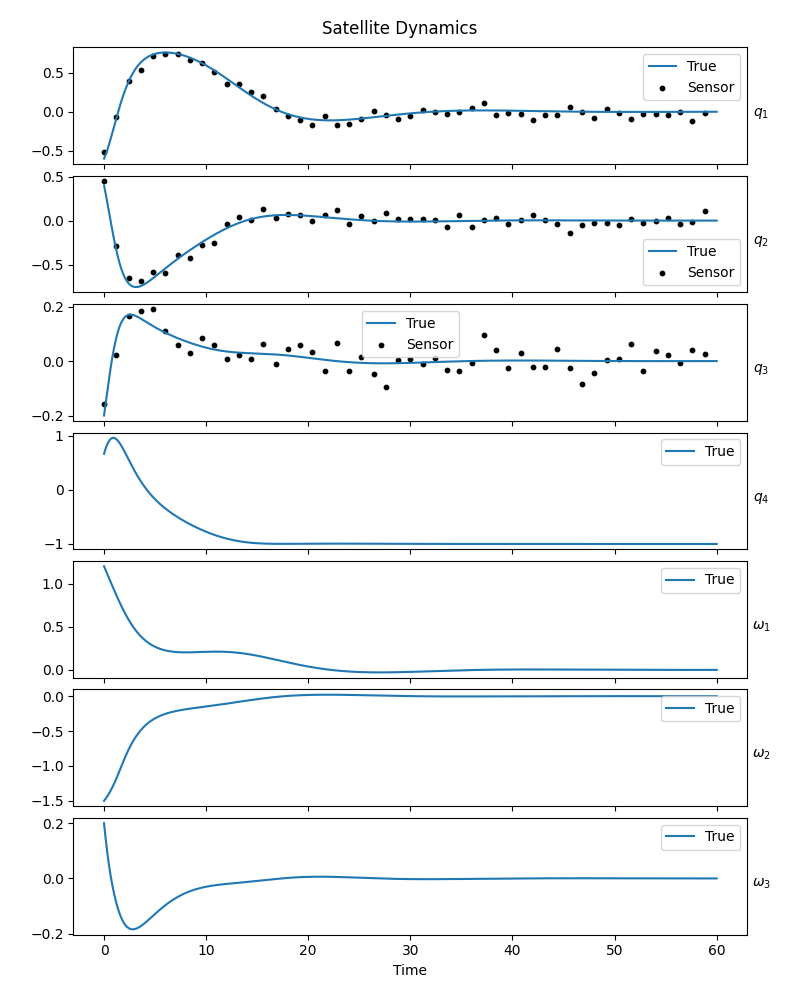

In [19]:
# Set up simulation based on the burger_bayes notebook


@dataclass
class Solution:
    t: np.ndarray
    y: np.ndarray


@dataclass
class Observation:
    t: np.ndarray
    y: np.ndarray


T0 = 0
Tend = 60
Tsteps = 50
Tsteps_multiplier = 100  # increase the fidelity of the true solution
Teval = np.linspace(T0, Tend, Tsteps*Tsteps_multiplier)


def simulate_p1(params: np.ndarray) -> Solution:
    # problem 1: parameters k1, k2
    """Generate a solution for the states field for the given control params."""
    def f_p1(t, x):
        return f(t, x, params[0], params[1], J12_TRUE)
    sol = scipy.integrate.solve_ivp(
        fun=f_p1, t_span=(T0, Tend), y0=x0(), method='RK45', t_eval=Teval)

    return Solution(sol.t, sol.y)  # y = 7(dims) x Tsteps(500)


def simulate_p2(params: np.ndarray) -> Solution:
    # problem 2: parameters k1, k2, j12
    """Generate a solution for the states field for the given control params."""
    def f_p2(t, x):
        return f(t, x, params[0], params[1], params[2])
    sol = scipy.integrate.solve_ivp(
        fun=f_p2, t_span=(T0, Tend), y0=x0(), method='RK45', t_eval=Teval)

    return Solution(sol.t, sol.y)  # y = 7(dims) x Tsteps(500)


def sensor(solution: Solution) -> Observation:
    """Sensor model that extracts data from the solution."""
    # pick out every Tsteps_multiplier-th solution point
    idx_obs = np.arange(0, solution.t.shape[0], Tsteps_multiplier)
    return Observation(solution.t[idx_obs], solution.y[:3, idx_obs])


def generate_data(true_k1=K1_TRUE, true_k2=K2_TRUE, true_j12=J12_TRUE, noise_std=NOISE_STD):
    true_sim = simulate_p2([true_k1, true_k2, true_j12])
    sensor_vals = sensor(true_sim)
    sensor_vals.y += noise_std * np.random.randn(sensor_vals.y.shape[0], sensor_vals.y.shape[1])
    return true_sim, sensor_vals


def plot_sat_dyn(fignum, t_true, x_true, t_sens, x_sens, x_names, title):
    plt.close(fignum)
    fig, axs = plt.subplots(x_true.shape[0], 1, sharex=True, num=fignum, figsize=(8, 10))
    fig.tight_layout(pad=3)
    fig.suptitle(title)
    for i, (ax, x_name) in enumerate(zip(axs, x_names)):
        ax.plot(t_true, x_true[i, :], label='True')
        if i < 3:
            ax.scatter(t_sens, x_sens[i, :], color='k', s=10, label='Sensor')
        ax.set_ylabel(x_name, rotation=0, labelpad=10)
        ax.yaxis.set_label_position("right")
        ax.legend()
    axs[-1].set_xlabel('Time')
    fig.subplots_adjust(hspace=0.1)
    fig.savefig(f'figs/{title}.svg')
    plt.show()
    return fignum + 1


# true output
np.random.seed(RAND_SEED)
data_sim, data_sens = generate_data()
fignum = 1
fignum = plot_sat_dyn(fignum, data_sim.t, data_sim.y, data_sens.t,
                      data_sens.y, X_NAMES, "Satellite Dynamics")

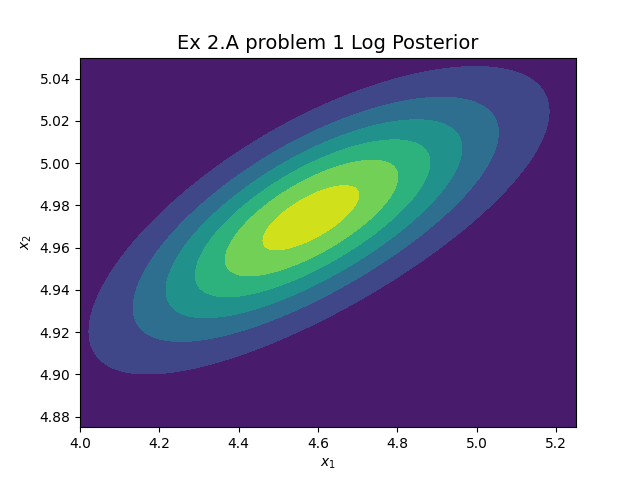

In [33]:
# set up bayes learning problem
def multigauss_logpdf(obs: np.ndarray, data: np.ndarray, cov: np.ndarray) -> float:
    """
    Calculates the logpdf of observing the given data under a multivariate Gaussian distribution.
    Each observation MUST have its own data point as the mean and the same covariance matrix.

    Parameters:
    obs (numpy.ndarray): The observed data points, with shape (n_samples, n_features).
    data (numpy.ndarray): The mean of the multivariate Gaussian distribution, with shape (n_samples, n_features).
    cov (numpy.ndarray): The covariance matrix of the multivariate Gaussian distribution, with shape (n_features, n_features).

    Returns:
    float: The logpdf of observing the data under the multivariate Gaussian distribution.
    """
    dims = obs.shape[1]
    diff = obs - data
    const_term = dims * np.log(2 * np.pi) + np.log(np.linalg.det(cov))
    exponent_term = np.sum(np.dot(diff, np.linalg.inv(cov)) * diff, axis=1)
    return -0.5 * np.sum((const_term + exponent_term))


def log_prior(params: np.ndarray) -> float:
    # indep gaussian prior on k1, k2 with 0 mean and 1 variance
    # this returns an array for some reason, get the first element for float
    return lognormpdf(params.reshape(-1, 1), np.zeros(params.size), np.eye(params.size))[0]


def log_likelihood(sim_func: Callable, data: Observation, params: np.ndarray) -> float:
    # gaussian likelihood on the difference between the sensor data
    # and model output for the given parameters
    sim = sim_func(params)
    obs = sensor(sim)
    cov = NOISE_STD**2 * np.eye(obs.y.shape[0])
    return multigauss_logpdf(data.y.T, obs.y.T, cov)


def log_posterior(sim_func: Callable, params: np.ndarray, data: Observation) -> float:
    return log_prior(params) + log_likelihood(sim_func, data, params)


def compose(*functions):
    "Compose a list of functions"
    return functools.reduce(lambda f, g: lambda x: f(g(x)), functions, lambda x: x)


def plot_post(plt_id):
    plt.close(plt_id)
    plt.figure(plt_id)
    xgrid = np.linspace(4, 5.25, 100)
    ygrid = np.linspace(4.875, 5.05, 100)
    XX, YY = np.meshgrid(xgrid, ygrid)
    def func(params): return log_posterior(simulate_p1, params, data_sens)
    plt.contourf(XX, YY, eval_func_on_grid(compose(np.exp, func), xgrid, ygrid).T)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.title('Ex 2.A problem 1 Log Posterior', fontsize=14)
    plt.savefig('figs/logpost_2.A.1.svg')
    return plt_id+1


# test log_likelihood, for accuracy and speed
# dims = 3
# N = 5000
# obs = np.random.randn(dims, N)
# data = np.random.randn(dims, N)
# cov = np.array([[2, 0.5, 0.3],
#                 [0.5, 3, 0.2],
#                 [0.3, 0.2, 1]])
# # cov=NOISE_STD**2 * np.eye(obs.shape[0])

# start = perf_counter()
# sum1 = 0
# for col in range(data.shape[1]):
#     sum1 += multivariate_normal.logpdf(obs[:, col], mean=data[:, col],
#                                        cov=cov)
# time1 = perf_counter() - start
# print(f'{sum1} in {time1} s')
# start = perf_counter()
# sum2 = multigauss_logpdf(obs.T, data.T, cov)
# time2 = perf_counter() - start
# print(f'{sum2} in {time2} s')
# print(f'{time1/time2} times faster')

fignum = plot_post(fignum)

In [21]:
# Find starting point for MCMC

def laplace_approx(initial_guess, logpost):
    """Perform the laplace approximation.

    Return the MAP point and an approximation of the covariance

    Inputs
    ------
    initial_guess: (nparam, ) array of initial parameters
    logpost: function (param) -> log posterior

    Ouputs
    ------
    map_point: (nparam, ) MAP of the posterior
    cov_approx: (nparam, nparam), covariance matrix for Gaussian fit at MAP
    """
    def neg_post(x):
        """Negative posteror because optimizer is a minimizer"""
        return -logpost(x)

    # Gradient free method to obtain optimum
    res = scipy.optimize.minimize(neg_post, initial_guess, method='Nelder-Mead')
    # Gradient method which also approximates the inverse of the hessian
    res = scipy.optimize.minimize(neg_post, res.x)

    map_point = res.x
    cov_approx = res.hess_inv
    return map_point, cov_approx


def logpost_p1(params): return log_posterior(simulate_p1, params, data_sens)
def logpost_p2(params): return log_posterior(simulate_p2, params, data_sens)


np.random.seed(RAND_SEED)
init_sample_p1 = np.random.randn(2)
map_p1, cov_approx_p1 = laplace_approx(np.array(init_sample_p1), logpost_p1)
print(f"Problem 1:\n- MAP: {map_p1}\n- Covariance:\n{cov_approx_p1}")
init_sample_p2 = np.array([*map_p1, np.random.randn()])
map_p2, cov_approx_p2 = laplace_approx(np.array(init_sample_p2), logpost_p2)
print(f"Problem 2:\n- MAP: {map_p2}\n- Covariance:\n{cov_approx_p2}")

# scale the covariance according to eq 16.6 in the notes
cov_approx_p1 = cov_approx_p1 / init_sample_p1.shape[0] * 2.4**2
cov_approx_p2 = cov_approx_p2 / init_sample_p2.shape[0] * 2.4**2

Problem 1:
- MAP: [4.58036977 4.9741691 ]
- Covariance:
[[7.93682358e-04 9.98701965e-05]
 [9.98701965e-05 8.45339033e-04]]
Problem 2:
- MAP: [4.55097817 4.87289835 1.59590382]
- Covariance:
[[ 0.41633299  0.04682591 -0.04070503]
 [ 0.04682591  0.01172861 -0.02774891]
 [-0.04070503 -0.02774891  0.09664516]]


In [26]:
# Set up MCMC
def prop_rw_cov_sampler(x: np.ndarray, cov: np.ndarray) -> np.ndarray:
    """Sample from a random walk proposal with covariance `cov`."""
    # propose using cholesky decomposition https://juanitorduz.github.io/multivariate_normal/
    # inversion is different than cholesky
    # https://stats.stackexchange.com/questions/503058/relationship-between-cholesky-decomposition-and-matrix-inversion
    return x + np.dot(np.linalg.cholesky(cov), np.random.randn(x.shape[0]))
    # use the lognormpdf to get the pdf for this


class DelayedRejectionAdaptiveMetropolis:

    def __init__(self, target_logpdf, cov, adapt_time=100, sd=None, max_samples=10000, eps=1e-7, gamma=0.5):
        """The class constructor, parameters are documented below"""
        self.target_logpdf = target_logpdf  # callable (param) -> logpdf defining the logpdf
        self.cov_est = cov  # proposal covariance
        self.cov_init = cov  # initial covariance
        self.dims = cov.shape[0]  # number of parameters
        # self.cov_chol = np.linalg.cholesky(cov)  # sqrt of the covariance
        self.dim = cov.shape[0]  # number of parameters
        self.adapt_time = adapt_time  # time to start adapting
        # self.adapt_freq = adapt_freq  # frequency of covariance updates (should be an integer > 0)
        if sd == None:
            self.sd = (2.4**2) / self.dim
        else:
            self.sd = sd  # scale for the covariance
        self.max_samples = max_samples  # maximum number of samples
        self.eps = eps  # nugget for ensuring positive definite
        self.gamma = gamma  # scale for the second proposal
        self.num_samples = 0  # number of samples generated
        self.samples = np.zeros((max_samples, self.dim))  # store the samples
        self.sample_mean = np.zeros((self.dim))  # store the sample mean
        self.target_logpdf_vals = np.zeros((max_samples))

    def a1(self, fx_x, fx_y):
        """ Acceptance probability given a symmetric proposal"""
        return min(np.exp(fx_y - fx_x), 1)

    def a2(self, fx_x, fx_y1, fx_y2, x, y1, y2, proposal1_func):
        """ Acceptance probability given a symmetric proposal"""
        q1_y2y1 = proposal1_func(y2, y1)
        q1_xy1 = proposal1_func(x, y1)
        a1_top = np.log(1-self.a1(fx_y2, fx_y1))
        a1_bot = np.log(1-self.a1(fx_x, fx_y1))
        check = fx_y2 - fx_x + q1_y2y1 - q1_xy1 + a1_top - a1_bot
        if check < 0:
            return np.exp(check)
        return 1.0

    def recur_mean(self, k, mean, x):
        return 1/(k+1) * x + k/(k+1) * mean

    def recur_cov_prop(self, k, cov_prop_k, sd, xi, mean_km1, mean_k, x_k):
        return (k-1)/k * cov_prop_k + sd/k * \
            (xi*np.eye(self.dims)
             + k*np.outer(mean_km1, mean_km1)
             - (k+1)*np.outer(mean_k, mean_k)
             + np.outer(x_k, x_k))

    def sample(self, initial_sample, num_samples):

        assert num_samples <= self.max_samples, "Requesting more samples than space is allocated for"

        self.samples[0, :] = initial_sample
        self.sample_mean = self.recur_mean(0, self.sample_mean, initial_sample)
        self.target_logpdf_vals[0] = self.target_logpdf(initial_sample)

        num_accept = 1
        for ii in range(1, num_samples):

            # proposed1_sample = self.samples[ii-1, :] + \
            #     np.dot(self.cov_chol, np.random.randn(self.dim))
            if ii <= self.adapt_time:
                cov_use = self.cov_init
            else:
                cov_use = self.cov_est

            proposed1_sample = prop_rw_cov_sampler(self.samples[ii-1, :], cov_use)
            proposed1_target_logpdf = self.target_logpdf(proposed1_sample)
            print(f'proposed1_sample: {proposed1_sample}')

            # compute accept-reject probability, using the fact that we have a symmetric proposal
            # a1 = np.exp(proposed1_target_logpdf - self.target_logpdf_vals[ii-1])
            # a1 = min(a1, 1)
            a1 = self.a1(self.target_logpdf_vals[ii-1], proposed1_target_logpdf)

            u = np.random.rand()
            if u < a1:  # accept
                self.samples[ii, :] = proposed1_sample
                self.target_logpdf_vals[ii] = proposed1_target_logpdf
                num_accept += 1
            else:  # rejected, try a second proposal with a scaled proposal
                # cov2 = self.cov * self.gamma
                # cov_chol2 = np.linalg.cholesky(cov2)
                # cov_inv = np.linalg.inv(self.cov)
                # proposed2_sample = self.samples[ii-1, :] + \
                #     np.dot(cov_chol2, np.random.randn(self.dim))
                proposed2_sample = prop_rw_cov_sampler(self.samples[ii-1, :], cov_use * self.gamma)
                print(f'proposed2_sample: {proposed2_sample}')
                proposed2_target_logpdf = self.target_logpdf(proposed2_sample)

                # def propose1_logpdf(x, y):

                #     """ Probability of moving from x to y (in this case it is symmetric)."""
                #     delta = x - y
                #     return -0.5 * (delta.T @ cov_inv @ delta)
                def propose1_logpdf(x, y): return lognormpdf(y.reshape(self.dims, 1), x, cov_use)

                # compute accept-reject probability, using the fact that we have a symmetric proposal
                a2 = self.a2(self.target_logpdf_vals[ii-1], proposed1_target_logpdf,
                             proposed2_target_logpdf, self.samples[ii-1, :], proposed1_sample,
                             proposed2_sample, propose1_logpdf)
                u = np.random.rand()
                if u < a2:
                    self.samples[ii, :] = proposed2_sample
                    self.target_logpdf_vals[ii] = proposed2_target_logpdf
                    num_accept += 1
                else:
                    print('Both proposals rejected')
                    self.samples[ii, :] = self.samples[ii-1, :]
                    self.target_logpdf_vals[ii] = self.target_logpdf_vals[ii-1]

            self.num_samples += 1
            mean_km1 = self.sample_mean
            self.sample_mean = self.recur_mean(ii, self.sample_mean, self.samples[ii, :])
            self.cov_est = self.recur_cov_prop(ii, self.cov_est, self.sd,
                                               self.eps, mean_km1, self.sample_mean, self.samples[ii, :])
            # adapt covariance if its time
            # if ii > self.adapt_time and ii % self.adapt_freq == 0:
            # THE NEXT TWO LINES ARE UNACCEPTABLE IN YOUR PROJECT
            # sample_cov = np.cov(self.samples[:self.num_samples, :], rowvar=False)
            # self.cov_prop = self.sd * (sample_cov + self.eps * np.eye(self.dim))
            # self.cov_chol = np.linalg.cholesky(self.cov_prop)

            if ii % 1000 == 0:
                print(f"Finished sample {ii}, acceptance ratio = {num_accept / self.num_samples}")
        # print(f'cov: {self.cov_prop}')
        return self.samples, num_accept / float(self.num_samples - 1)

In [28]:
# run MCMC for problem 1
NUM_SAMPLES = 20000
COV_SCALE_P1 = 100
GAMMA_P1 = 0.5
np.random.seed(RAND_SEED)
dram_p1 = DelayedRejectionAdaptiveMetropolis(
    logpost_p1, cov_approx_p1*COV_SCALE_P1, max_samples=NUM_SAMPLES, gamma=GAMMA_P1)
s_dram_p1, ar_dram_p1 = dram_p1.sample(map_p1, NUM_SAMPLES)
print(f'Problem 1:\n- Acceptance ratio: {ar_dram_p1}\n- Sample mean: {np.mean(s_dram_p1, axis=0)}')

proposed1_sample: [5.43551475 5.2955465 ]
proposed2_sample: [4.91186407 5.02523802]
proposed1_sample: [4.77924451 4.83481314]
proposed2_sample: [4.75633836 4.98561038]
proposed1_sample: [4.12817837 5.33979687]
proposed2_sample: [4.63891699 4.99379391]
proposed1_sample: [4.37817988 4.20362402]
proposed2_sample: [4.44932488 5.59983914]
Both proposals rejected
proposed1_sample: [5.34944594 5.19912855]
proposed2_sample: [4.45817542 4.51155789]
Both proposals rejected
proposed1_sample: [4.2713356  4.83488698]
proposed2_sample: [3.95443258 5.20061234]
Both proposals rejected
proposed1_sample: [4.25463566 3.7607344 ]
proposed2_sample: [4.51434329 4.35023095]


/tmp/ipykernel_785743/3048721282.py:43: RuntimeWarning: divide by zero encountered in log
  a1_top = np.log(1-self.a1(fx_y2, fx_y1))


Both proposals rejected
proposed1_sample: [3.86282268 5.21283514]
proposed2_sample: [4.15828419 4.85747834]
Both proposals rejected
proposed1_sample: [4.22111304 4.95577287]
proposed2_sample: [5.10896096 4.73342328]
Both proposals rejected
proposed1_sample: [5.16874249 5.60866514]
proposed2_sample: [4.23050635 5.38160455]
Both proposals rejected
proposed1_sample: [4.35067705 4.01994414]
proposed2_sample: [4.89091767 4.66230276]
Both proposals rejected
proposed1_sample: [4.54453285 5.85101963]
proposed2_sample: [4.49168269 4.84486133]
Both proposals rejected
proposed1_sample: [4.71204048 4.48182361]
proposed2_sample: [4.6794801  5.10233185]
Both proposals rejected
proposed1_sample: [4.14889657 5.37256963]
proposed2_sample: [4.80837916 5.27527575]
Both proposals rejected
proposed1_sample: [4.87021666 5.35406416]
proposed2_sample: [4.71643306 5.24946361]
Both proposals rejected
proposed1_sample: [3.98359884 5.02816654]
proposed2_sample: [4.93823111 5.27428106]
Both proposals rejected
prop

/tmp/ipykernel_785743/3048721282.py:37: RuntimeWarning: overflow encountered in exp
  return min(np.exp(fx_y - fx_x), 1)


Both proposals rejected
proposed1_sample: [4.66144683 5.30064441]
proposed2_sample: [4.80835208 5.13664016]
Both proposals rejected
proposed1_sample: [5.20837057 4.9744835 ]
proposed2_sample: [4.53583214 4.95928788]
proposed1_sample: [3.66145451 4.81033854]
proposed2_sample: [4.52610062 4.4476465 ]
Both proposals rejected
proposed1_sample: [5.09320792 5.43281012]
proposed2_sample: [4.08806433 4.11277472]
Both proposals rejected
proposed1_sample: [5.17685626 4.66144562]
proposed2_sample: [4.56660803 5.23515055]
Both proposals rejected
proposed1_sample: [5.25533179 5.53894016]
proposed2_sample: [4.34295318 4.23236312]
Both proposals rejected
proposed1_sample: [4.17290373 4.69511297]
proposed2_sample: [4.56650061 4.19526959]
Both proposals rejected
proposed1_sample: [4.79950945 4.54729813]
proposed2_sample: [4.97460357 4.48978976]
Both proposals rejected
proposed1_sample: [3.35598056 4.87316976]
proposed2_sample: [4.19918554 5.03598096]
Both proposals rejected
proposed1_sample: [4.3925364

KeyboardInterrupt: 

In [24]:
# run MCMC for problem 2
NUM_SAMPLES = 20000
np.random.seed(RAND_SEED)
COV_SCALE_P2 = 100
GAMMA_P2 = 0.5
dram_p2 = DelayedRejectionAdaptiveMetropolis(
    logpost_p2, cov_approx_p2*COV_SCALE_P2, max_samples=NUM_SAMPLES, gamma=GAMMA_P2)
s_dram_p2, ar_dram_p2 = dram_p2.sample(map_p2, NUM_SAMPLES)
print(f'Problem 2:\n- Acceptance ratio: {ar_dram_p2}\n- Sample mean: {np.mean(s_dram_p2, axis=0)}')

/tmp/ipykernel_785743/2595271000.py:37: RuntimeWarning: overflow encountered in exp
  return min(np.exp(fx_y - fx_x), 1)
/tmp/ipykernel_785743/2595271000.py:43: RuntimeWarning: divide by zero encountered in log
  a1_top = np.log(1-self.a1(fx_y2, fx_y1))


Finished sample 1000, acceptance ratio = 0.667
Finished sample 2000, acceptance ratio = 0.6405
Finished sample 3000, acceptance ratio = 0.615
Finished sample 4000, acceptance ratio = 0.5965
Finished sample 5000, acceptance ratio = 0.5974
Finished sample 6000, acceptance ratio = 0.5906666666666667


KeyboardInterrupt: 